### Example of binary classification problem

In [1]:
# Data
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"Firstl 5 samples of X:\n {X[:5]}")
print(f"Firstl 5 samples of y:\n {y[:5]}")

Firstl 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Firstl 5 samples of y:
 [1 1 1 1 0]


In [5]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


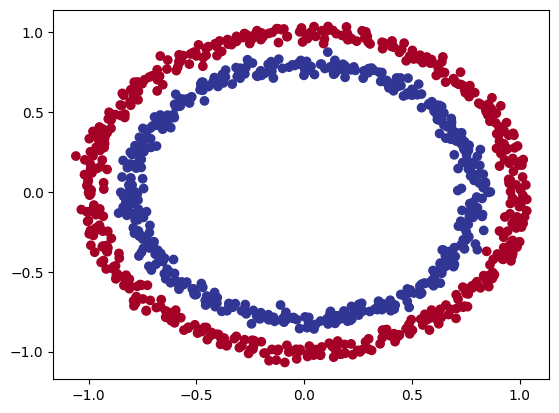

In [6]:
# Plot the dataset
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
# Check shape of the dataset
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# Turn data into tensors
import torch
torch.__version__

'2.3.0+cu121'

In [9]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
# Build a model
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [15]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)

  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> l1 -> l2

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Other way to create a model using Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3835, -0.1154],
                      [ 0.1218, -0.1744],
                      [-0.4579,  0.0272],
                      [-0.3456,  0.3187],
                      [ 0.2047, -0.5456]])),
             ('0.bias', tensor([ 0.6217, -0.6342, -0.3511, -0.0363,  0.4831])),
             ('1.weight',
              tensor([[-0.2191,  0.0185, -0.0209, -0.3719,  0.2883]])),
             ('1.bias', tensor([0.1584]))])

In [18]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predicitons:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predicitons:
tensor([[-0.0464],
        [-0.0719],
        [ 0.1695],
        [-0.1082],
        [ 0.4060],
        [ 0.3886],
        [ 0.1293],
        [ 0.2378],
        [ 0.1592],
        [-0.0710]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [19]:
# Set loss, optimizer and eval functions
# nn.BCELoss() does not have built-in sigmoid activation function
criterion = nn.BCEWithLogitsLoss() # built-in sigmoid activation function

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.1)

In [20]:
# Calculate accuracy
def calc_accuracy(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [21]:
# Train a model
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = criterion(y_logits, # nn.BCEWithLogitsLoss expects logits
                   y_train)

  acc = calc_accuracy(y_true=y_train,
                      y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = criterion(test_logits,
                          y_test)
    test_acc = calc_accuracy(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0, Loss: 0.70206, Acc: 52.00%, Test loss: 0.69779, Test acc: 50.00%
Epoch: 10, Loss: 0.69402, Acc: 46.25%, Test loss: 0.69657, Test acc: 44.00%
Epoch: 20, Loss: 0.69306, Acc: 51.25%, Test loss: 0.69495, Test acc: 47.00%
Epoch: 30, Loss: 0.69310, Acc: 52.88%, Test loss: 0.69516, Test acc: 49.00%
Epoch: 40, Loss: 0.69298, Acc: 51.25%, Test loss: 0.69468, Test acc: 47.50%
Epoch: 50, Loss: 0.69299, Acc: 50.12%, Test loss: 0.69450, Test acc: 46.00%
Epoch: 60, Loss: 0.69298, Acc: 51.00%, Test loss: 0.69472, Test acc: 46.50%
Epoch: 70, Loss: 0.69298, Acc: 51.38%, Test loss: 0.69472, Test acc: 46.00%
Epoch: 80, Loss: 0.69298, Acc: 51.62%, Test loss: 0.69465, Test acc: 46.00%
Epoch: 90, Loss: 0.69298, Acc: 51.50%, Test loss: 0.69469, Test acc: 45.50%


In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


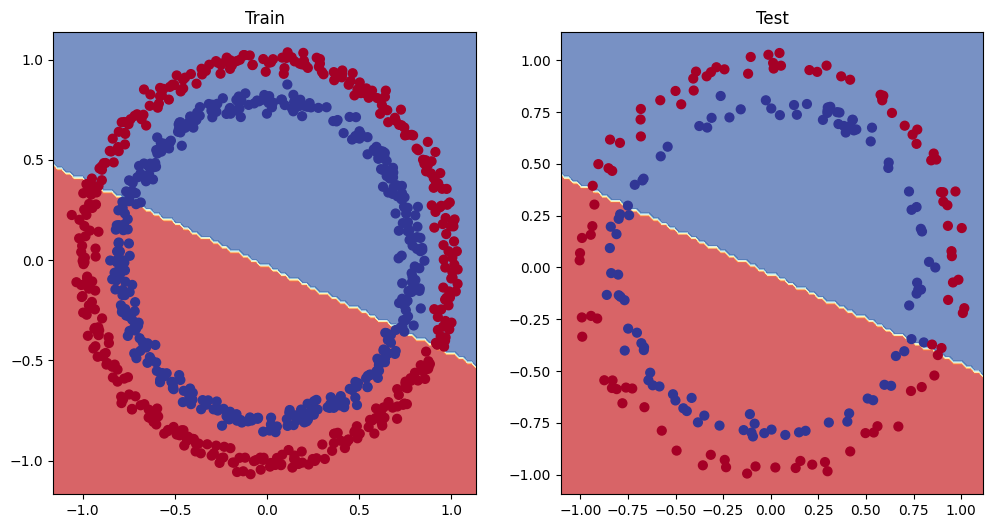

In [23]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [24]:
# Improving a model (from a model perspective)
# 1. Add more layers
# 2. Add more units per hidden layer
# 3. For for longer (more epochs)
# 4. Change the activation functions
# 5. Change the learning rate
# 6. Change the loss function

In [25]:
# Changing the model (in this case we need to add nonlinearity)
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 3 layers
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # x -> l1 -> relu -> l2 -> relu -> l3

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [26]:
# Set loss, optimizer and eval functions
# nn.BCELoss() does not have built-in sigmoid activation function
criterion = nn.BCEWithLogitsLoss() # built-in sigmoid activation function

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.1)

In [27]:
# Train new model
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = criterion(y_logits, # nn.BCEWithLogitsLoss expects logits
                   y_train)

  acc = calc_accuracy(y_true=y_train,
                      y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = criterion(test_logits,
                          y_test)
    test_acc = calc_accuracy(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0, Loss: 0.69295, Acc: 50.00%, Test loss: 0.69394, Test acc: 50.00%
Epoch: 10, Loss: 0.58281, Acc: 69.00%, Test loss: 0.55994, Test acc: 75.00%
Epoch: 20, Loss: 0.20353, Acc: 99.38%, Test loss: 0.19835, Test acc: 97.50%
Epoch: 30, Loss: 0.03641, Acc: 99.50%, Test loss: 0.05927, Test acc: 98.50%
Epoch: 40, Loss: 0.01162, Acc: 100.00%, Test loss: 0.02676, Test acc: 99.50%
Epoch: 50, Loss: 0.00580, Acc: 100.00%, Test loss: 0.02004, Test acc: 99.00%
Epoch: 60, Loss: 0.00364, Acc: 100.00%, Test loss: 0.01296, Test acc: 99.50%
Epoch: 70, Loss: 0.00271, Acc: 100.00%, Test loss: 0.00922, Test acc: 100.00%
Epoch: 80, Loss: 0.00222, Acc: 100.00%, Test loss: 0.00857, Test acc: 100.00%
Epoch: 90, Loss: 0.00190, Acc: 100.00%, Test loss: 0.00761, Test acc: 100.00%


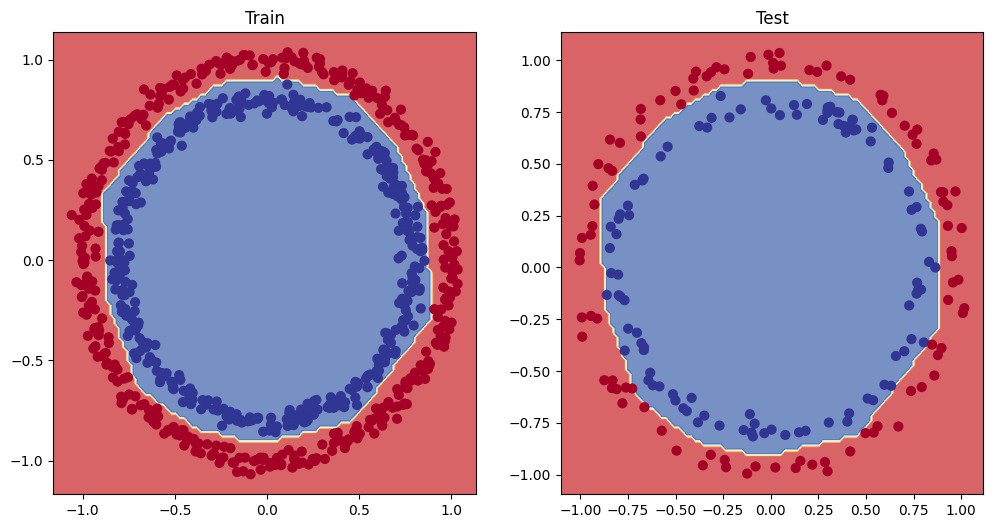

In [28]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Example of multiclass classification problem

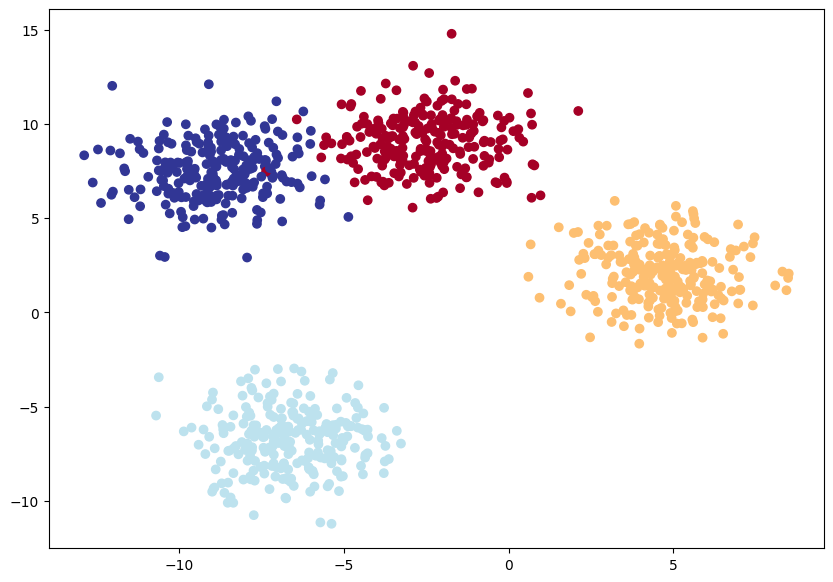

In [29]:
# Create data
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2,random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

In [30]:
# Build multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Args:
      input_features (int): Num of input features to the model
      output_features (int): Num of output features
      hidden_units (int): Num of hidden units between layers, default 8
    Returns:


    """
    super().__init__()
    # Create 3 layers
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_2 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [31]:
# Set loss, optimizer and eval functions
# nn.BCELoss() does not have built-in sigmoid activation function
criterion = nn.CrossEntropyLoss() # built-in sigmoid activation function

optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.1)

In [32]:
# Train new model
torch.manual_seed(42)

epochs = 30

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)


  loss = criterion(y_logits, # nn.BCEWithLogitsLoss expects logits
                   y_blob_train)

  acc = calc_accuracy(y_true=y_blob_train,
                      y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = criterion(test_logits,
                          y_blob_test)
    test_acc = calc_accuracy(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.5f}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0, Loss: 1.15883, Acc: 40.38%, Test loss: 0.81667, Test acc: 68.50%
Epoch: 10, Loss: 0.03970, Acc: 98.75%, Test loss: 0.01952, Test acc: 99.50%
Epoch: 20, Loss: 0.03161, Acc: 99.25%, Test loss: 0.00442, Test acc: 100.00%


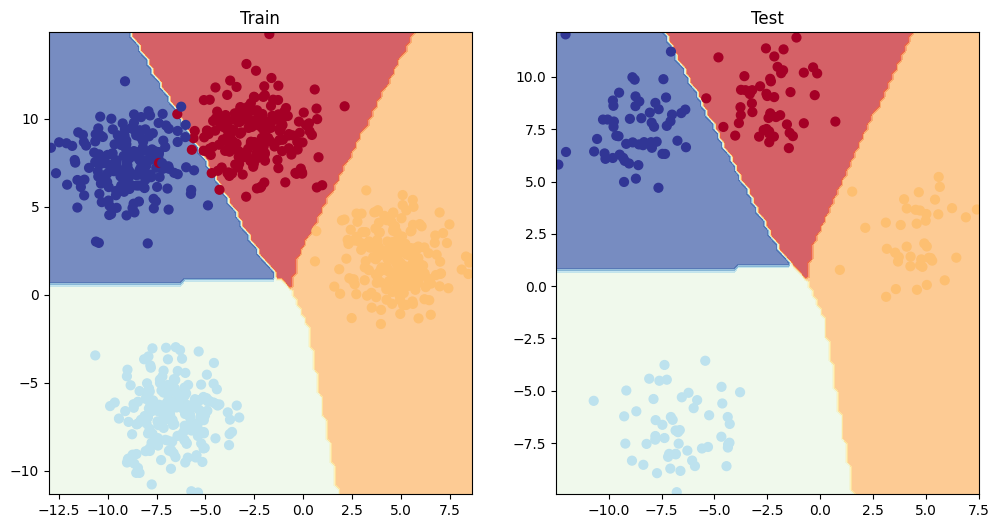

In [33]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)

If there is no ReLU layers, then classification works, but it is using straight lines:

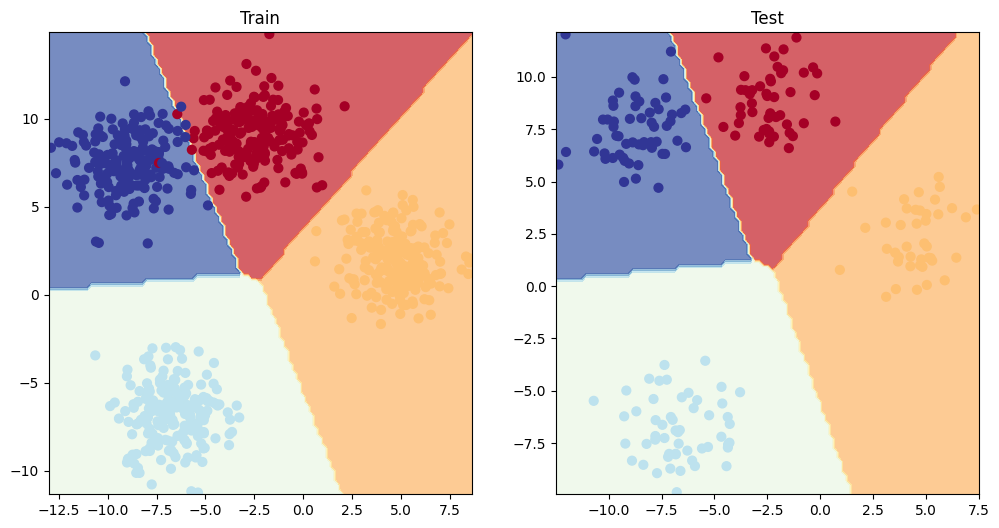

If using ReLU layers, then we get non-linear classification:

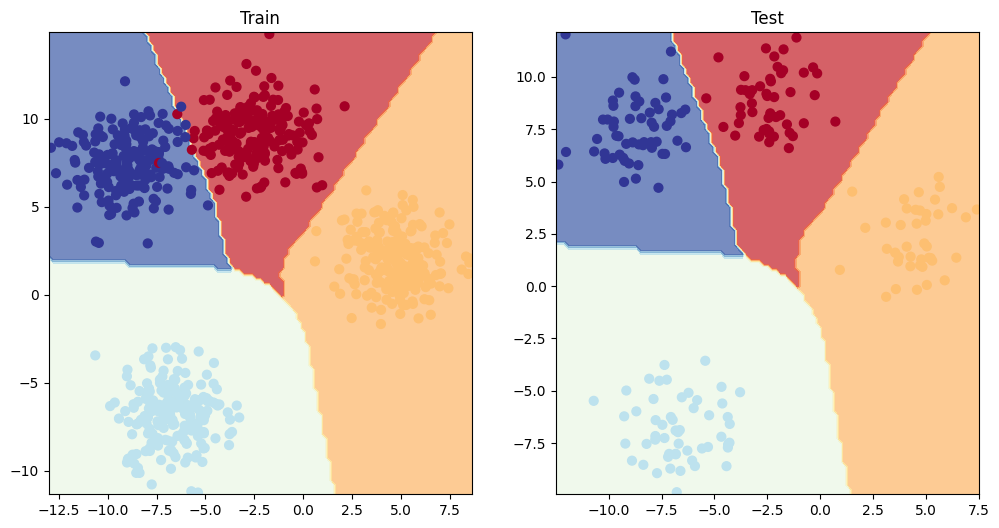